In [1]:
from __future__ import division
import os
import time
import math
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Conv2DTranspose, Activation, Reshape, LayerNormalization, BatchNormalization
from tensorflow.keras.layers import Input, Dropout, Concatenate, Dense, LeakyReLU, Flatten
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import plot_model

AUTOTUNE = tf.data.experimental.AUTOTUNE

MessageError: Error: credential propagation was unsuccessful

# Hyper parameters

In [ ]:
MODEL_NAME = 'DCGAN'
DATA_BASE_DIR = '/content/spec_128_'
output_dir = '/content/drive/MyDrive/GANProject/outputs_2'
TRAIN_LOGDIR = os.path.join(output_dir, "logs", "tensorflow", MODEL_NAME, 'train_data') # Sets up a log directory.
OUTPUT_PATH = os.path.join(output_dir, MODEL_NAME)
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

TARGET_IMG_SIZE = 128 # Scale images to this size

BATCH_SIZE = 64
NOISE_DIM = 100
LAMBDA = 10 # For gradient penalty

EPOCHs = 50
CURRENT_EPOCH = 1 # Epoch start from
SAVE_EVERY_N_EPOCH = 5 # Save checkpoint at every n epoch

N_CRITIC = 3 # Train critic(discriminator) n times then train generator 1 time.
LR = 1e-4
MIN_LR = 0.000001 # Minimum value of learning rate
DECAY_FACTOR=1.00004 # learning rate decay factor

# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(TRAIN_LOGDIR)

# Prepare dataset

In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

def load_audio_file(file_path, sr=22050):
    print("load_audio_file...")
    audio, sr = librosa.load(file_path, sr=sr, mono=True)
    return audio, sr

def audio_to_spectrogram(audio, n_fft=256, hop_length=128):
    print("audio_to_spectrogram")
    chunk_samples = int((n_fft/2 - 1)*hop_length + n_fft)
    num_chunks = int(np.ceil(len(audio) / chunk_samples))
    print(f"number of chunks: {num_chunks}")
    spectrograms = []
    for i in tqdm(range(num_chunks), desc='Processing audio chunks'):
        start = i*chunk_samples
        end = min((i + 1) * chunk_samples, len(audio))
        chunk = audio[start:end]
        if len(chunk) <= 100: #1초보다 짧으면..
            continue
        elif len(chunk) < chunk_samples:
            chunk = np.pad(chunk, (0, chunk_samples - len(chunk)), 'constant')  # 부족한 부분을 0으로 패딩'''
        # 스펙트로그램 계산
        audio_tf = tf.convert_to_tensor(chunk, dtype=tf.float32)
        S = tf.signal.stft(audio_tf, frame_length=n_fft, frame_step=hop_length)
        #print(f"dataSize{S.shape}")
        S_cropped = S[:128, :128]
        S_abs = tf.abs(S_cropped)
        if S_abs.numpy().size > 0:  # 비어 있지 않은 데이터만 처리
            S_db = librosa.amplitude_to_db(S_abs.numpy())
            spectrograms.append(S_db.T)
    print(".")
    return spectrograms

def save_spectrograms(spectrograms, output_dir, base_filename):
    # 지정된 디렉토리가 없을 경우 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created directory: {output_dir}")

    for i, spec in enumerate(spectrograms):
        np.save(os.path.join(output_dir, f"{base_filename}_chunk_{i}.npy"), spec)

def process_audio_files(folder_path, output_dir, start=0, end=10000):
    all_files = [os.path.join(root, file)
                 for root, dirs, files in os.walk(folder_path)
                 for file in files if file.endswith('.mp3') or file.endswith('.flac')]
    total_files = len(all_files)
    print(f"Total files to process: {total_files}")

    for index, file_path in enumerate(all_files):
        if index >= end: break
        if index < start: continue
        print(f"Processing file {index + 1} of {total_files}: {file_path}")
        base_filename = os.path.splitext(os.path.basename(file_path))[0]
        audio, sr = load_audio_file(file_path)
        spectrograms = audio_to_spectrogram(audio)
        save_spectrograms(spectrograms, output_dir, base_filename)

# 사용 예
input_folder = '/content/drive/My Drive/GANProject/GANpiano'
output_folder = DATA_BASE_DIR
process_audio_files(input_folder, output_folder)

In [ ]:
def load_spectrogram(file_path):
    # EagerTensor에서 바로 numpy 배열로 변환 후 decode
    file_path = file_path.numpy().decode()
    spec = np.load(file_path)
    spec = np.expand_dims(spec, axis=-1)  # 채널 차원 추가
    factor = np.max(spec) - np.min(spec)
    if factor > 0:
        spec = 2 * (spec - np.min(spec)) / factor - 1  # -1과 1 사이로 정규화
    return spec

def preprocess(file_path):
    # TensorFlow ops에서 사용할 수 있도록 load_spectrogram을 wrapper 함수로 호출
    spectrogram = tf.py_function(load_spectrogram, [file_path], Tout=[tf.float32])
    spectrogram = spectrogram[0]
    return spectrogram

def create_dataset(data_dir, batch_size=32):
    # 파일 경로 로드
    file_paths = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if fname.endswith('.npy')]
    print("file_paths")
    # TensorFlow Dataset 객체 생성
    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    print("tensor_slice")
    # 파일 경로를 실제 데이터로 변환
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    print("dataset.map")
    # 배치 처리 및 prefetching
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    print("dataset.batch")
    # 데이터셋의 배치 형태를 확인하기 위한 코드
    return dataset

train_data = create_dataset(DATA_BASE_DIR)

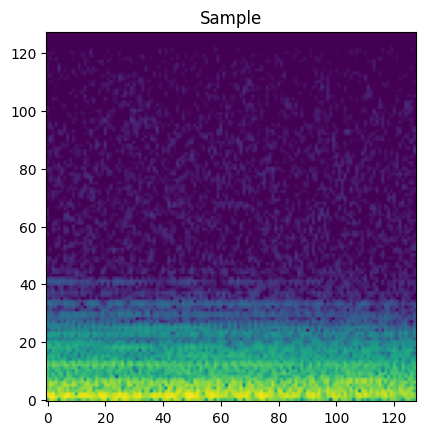

In [6]:
sample_img = next(iter(train_data))
plt.title('Sample')
plt.imshow(np.clip(sample_img[10] * 0.5 + 0.5, 0, 1), origin = 'lower')

# Prepare models

In [7]:
# You could also try layer normalization instead of batch normalization

def CGAN_generator(input_z_shape=NOISE_DIM):
    '''
        DCGAN like generator architecture
    '''
    input_z_layer = Input(input_z_shape)

    z = Dense(8*8*256, use_bias=False)(input_z_layer)
    z = Reshape((8, 8, 256))(z)

    x = Conv2DTranspose(256, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(z)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    output = Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation="tanh",
                             kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)

    model = Model(inputs=input_z_layer, outputs=output)
    return model

def CGAN_discriminator(input_x_shape=(TARGET_IMG_SIZE, TARGET_IMG_SIZE, 1)):
    '''
        DCGAN like discriminator architecture
    '''
    input_x_layer = Input(input_x_shape)

    x = Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(input_x_layer)
    #x = LayerNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    #x = LayerNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    #x = LayerNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    #x = LayerNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(1, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)

    x = Flatten()(x)

    output = Dense(1)(x)

    model = Model(inputs=input_x_layer, outputs=output)
    return model

In [8]:
generator = CGAN_generator()
generator.summary()
# Require extra packages to plot model
# plot_model(generator, show_shapes=True, dpi=64)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 256)         1048576   
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 8, 8, 256)         1024      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 256)         0     

In [9]:
discriminator = CGAN_discriminator()
discriminator.summary()
# Require extra packages to plot model
# plot_model(discriminator, show_shapes=True, dpi=64)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1024      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       131072    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       524288    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 256)       0   

In [10]:
# Optimizers
D_optimizer = Adam(learning_rate=LR, beta_1=0.5)
G_optimizer = Adam(learning_rate=LR, beta_1=0.5)

def learning_rate_decay(current_lr, decay_factor=DECAY_FACTOR):
    '''
        Calculate new learning rate using decay factor
    '''
    new_lr = max(current_lr / decay_factor, MIN_LR)
    return new_lr

def set_learning_rate(new_lr):
    '''
        Set new learning rate to optimizers
    '''
    K.set_value(D_optimizer.lr, new_lr)
    K.set_value(G_optimizer.lr, new_lr)

# Setup Checkpoints

In [11]:
checkpoint_path = os.path.join(output_dir, "checkpoints", MODEL_NAME)

ckpt = tf.train.Checkpoint(generator=generator,
                           discriminator=discriminator,
                           G_optimizer=G_optimizer,
                           D_optimizer=D_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    latest_epoch = int(ckpt_manager.latest_checkpoint.split('-')[1])
    CURRENT_EPOCH = latest_epoch * SAVE_EVERY_N_EPOCH
    print ('Latest checkpoint of epoch {} restored!!'.format(CURRENT_EPOCH))

Latest checkpoint of epoch 20 restored!!


In [12]:
def generate_and_save_images(model, epoch, test_input, figure_size=(12,6), subplot=(3,6), save=True, is_flatten=False):
    '''
        Generate images and plot it.
    '''
    predictions = model.predict(test_input)
    if is_flatten:
        predictions = predictions.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1).astype('float32')
    fig = plt.figure(figsize=figure_size)
    for i in range(predictions.shape[0]):
        axs = plt.subplot(subplot[0], subplot[1], i+1)
        plt.imshow(predictions[i] * 0.5 + 0.5, origin='lower')
        axs.set_xticks([])
        axs.set_yticks([])
        plt.axis('off')
    if save:
        plt.savefig(os.path.join(OUTPUT_PATH, 'image_at_epoch_{:04d}.png'.format(epoch)))
        data_filename = os.path.join(OUTPUT_PATH, 'data_at_epoch_{:04d}.npy'.format(epoch))
        np.save(data_filename, predictions)
    plt.show()

1/1 [==============================] - 2s 2s/step


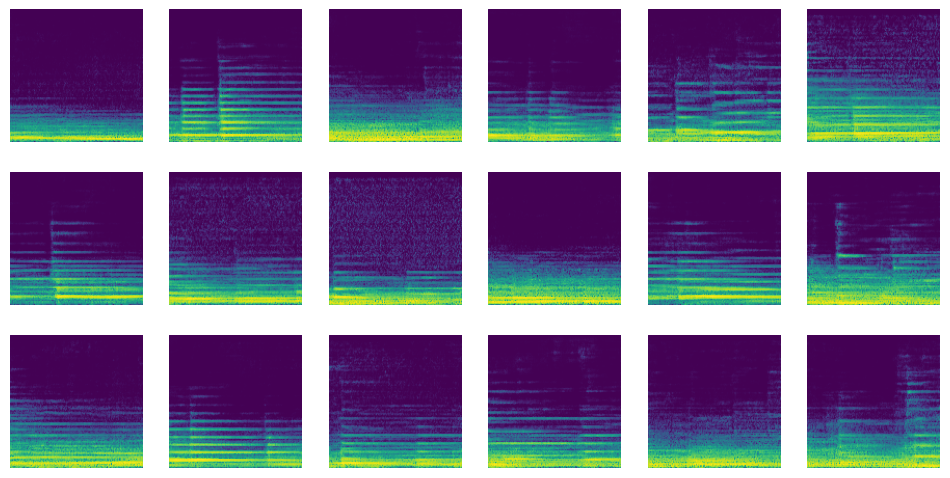

In [13]:
num_examples_to_generate = 18

# We will reuse this seed overtime
sample_noise = tf.random.normal([num_examples_to_generate, NOISE_DIM])
generate_and_save_images(generator, 0, [sample_noise], figure_size=(12,6), subplot=(3,6), save=False, is_flatten=False)

# Define training step

In [14]:
@tf.function
def WGAN_GP_train_d_step(real_image, batch_size, step):
    '''
        One discriminator training step

        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    print("retrace")
    noise = tf.random.normal([batch_size, NOISE_DIM])
    epsilon = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0, maxval=1)
    ###################################
    # Train D
    ###################################
    with tf.GradientTape(persistent=True) as d_tape:
        with tf.GradientTape() as gp_tape:
            fake_image = generator([noise], training=True)
            fake_image_mixed = epsilon * tf.dtypes.cast(real_image, tf.float32) + ((1 - epsilon) * fake_image)
            fake_mixed_pred = discriminator([fake_image_mixed], training=True)

        # Compute gradient penalty
        grads = gp_tape.gradient(fake_mixed_pred, fake_image_mixed)
        grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1))

        fake_pred = discriminator([fake_image], training=True)
        real_pred = discriminator([real_image], training=True)

        D_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + LAMBDA * gradient_penalty
    # Calculate the gradients for discriminator
    D_gradients = d_tape.gradient(D_loss,
                                            discriminator.trainable_variables)
    # Apply the gradients to the optimizer
    D_optimizer.apply_gradients(zip(D_gradients,
                                                discriminator.trainable_variables))
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('D_loss', tf.reduce_mean(D_loss), step=step)

@tf.function
def WGAN_GP_train_g_step(real_image, batch_size, step):
    '''
        One generator training step

        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    print("retrace")
    noise = tf.random.normal([batch_size, NOISE_DIM])
    ###################################
    # Train G
    ###################################
    with tf.GradientTape() as g_tape:
        fake_image = generator([noise], training=True)
        fake_pred = discriminator([fake_image], training=True)
        G_loss = -tf.reduce_mean(fake_pred)
    # Calculate the gradients for generator
    G_gradients = g_tape.gradient(G_loss,
                                            generator.trainable_variables)
    # Apply the gradients to the optimizer
    G_optimizer.apply_gradients(zip(G_gradients,
                                                generator.trainable_variables))
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('G_loss', G_loss, step=step)

# Start training

1/1 [==============================] - 0s 22ms/step


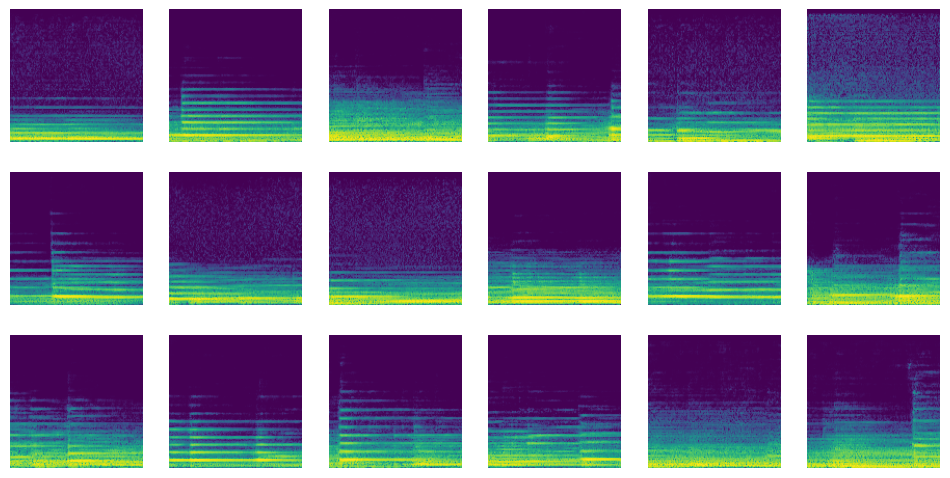

Saving checkpoint for epoch 50 at /content/drive/MyDrive/GANProject/outputs_2/checkpoints/DCGAN/ckpt-11
Time taken for epoch 50 is 114.44747281074524 sec

Saving checkpoint for epoch 50 at /content/drive/MyDrive/GANProject/outputs_2/checkpoints/DCGAN/ckpt-12


In [15]:
current_learning_rate = LR
trace = True
n_critic_count = 0

for epoch in range(CURRENT_EPOCH, EPOCHs + 1):
    start = time.time()
    print('Start of epoch %d' % (epoch,))
    # Using learning rate decay
    current_learning_rate = learning_rate_decay(current_learning_rate)
    print('current_learning_rate %f' % (current_learning_rate,))
    set_learning_rate(current_learning_rate)

    for step, (image) in enumerate(train_data):
        current_batch_size = image.shape[0]
        # Train critic (discriminator)
        WGAN_GP_train_d_step(image, batch_size=tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
        n_critic_count += 1
        if n_critic_count >= N_CRITIC:
            # Train generator
            WGAN_GP_train_g_step(image, batch_size= tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
            n_critic_count = 0

        if step % 10 == 0:
            print ('.', end='')

    # Clear jupyter notebook cell output
    clear_output(wait=True)
    # Using a consistent sample so that the progress of the model is clearly visible.
    generate_and_save_images(generator, epoch, [sample_noise], figure_size=(12,6), subplot=(3,6), save=True, is_flatten=False)

    if epoch % SAVE_EVERY_N_EPOCH == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                             ckpt_save_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                      time.time()-start))

# Save at final epoch
ckpt_save_path = ckpt_manager.save()
print ('Saving checkpoint for epoch {} at {}'.format(EPOCHs,
                                                        ckpt_save_path))


In [ ]:
# Use new sample to see the performance of the model.
test_noise = tf.random.normal([64, NOISE_DIM])
prediction = generator.predict(test_noise)

In [ ]:
def image_grid(images, fig):
    # Create a figure to contain the plot.
    for i in range(64):
        # Start next subplot.
        axs = fig.add_subplot(8, 8, i + 1)
        axs.set_xticks([])
        axs.set_yticks([])
        axs.imshow(np.clip(images[i] * 0.5 + 0.5, 0, 1))

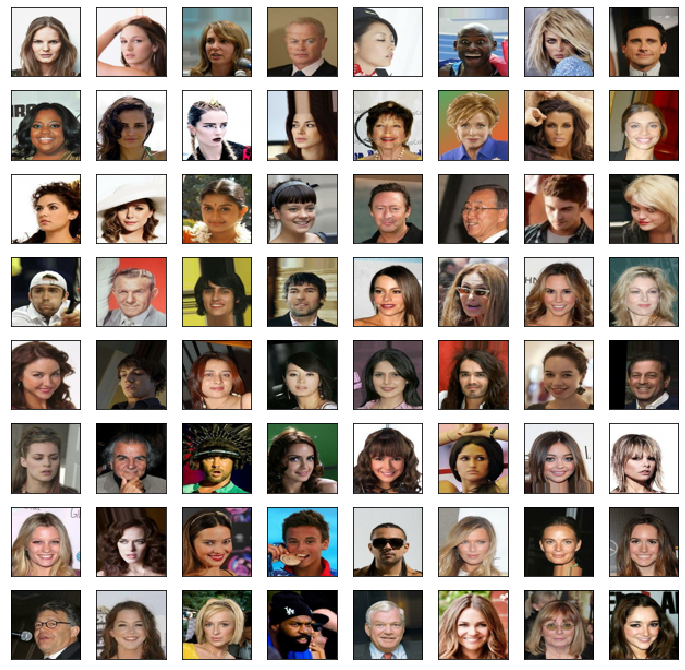

In [ ]:
# Plot the real images for dataset
fig1 = plt.figure(figsize=(12,12))
image_grid(sample_img.numpy()[:64], fig1)
plt.show()

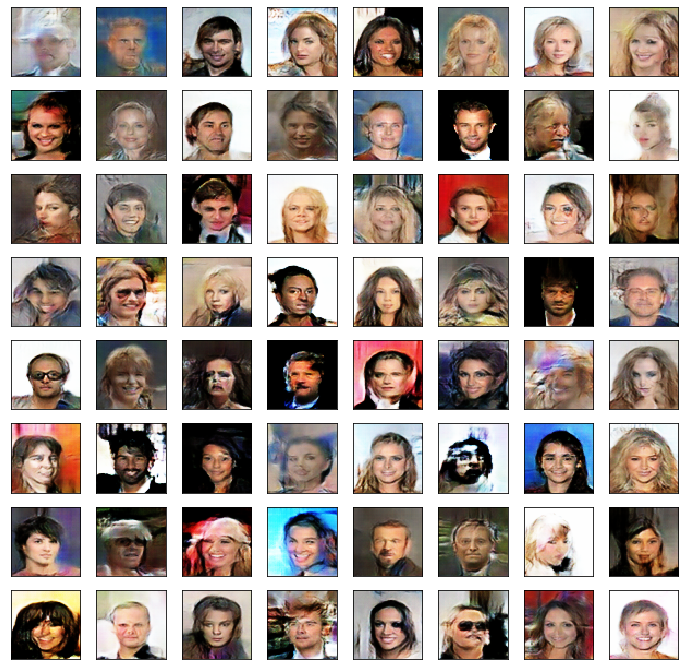

In [ ]:
# Plot the fake images from the last epoch
fig2 = plt.figure(figsize=(12,12))
image_grid(prediction, fig2)